# Project Statement: Forecasting Air Pollution in Quito Using Time Series Analysis and Machine Learning

#### Integrantes:
- Enrique Merizalde
- Juan Aristizabal
- Domenica Escobar
- Jossue Játiva

#### Fecha de inicio: 12/04/2025

## CARGAR Y CONSOLIDAR:

Cargar conjunto de datos de 10 estaciones con variables como PM2.5, CO2 y Velocidad del viento. Consolidar en un DataFrame unificado, gestionando los datos faltantes con imputacion y visualizando las lagunas con missingno. Estandarizar formatos y remuestrar para predicciones mensuales (Suma de precipitación, media, etc.) y horas mediante pandas

In [66]:
import os
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

In [67]:
# Ruta de la carpeta con los archivos CSV
folder_path = 'Data/'

# Obtener la lista de archivos CSV
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Cargar el archivo estaciones.csv para obtener LAT y LON
estaciones_path = os.path.join(folder_path, 'estaciones.csv')
estaciones_df = pd.read_csv(estaciones_path)

# Crear un DataFrame vacío con las columnas esperadas
column_names = [
    "STATION_NAME", "LAT", "LON", "Date_time",
    "CO", "DIR", "HUM", "LLU", "NO2", "O3",
    "PM2.5", "PM10", "PRE", "RS", "TMP", "VEL"
]
final_df = pd.DataFrame(columns=column_names)

In [68]:
# Iterar sobre cada archivo CSV
for file in csv_files:
    if file == 'estaciones.csv':
        continue  # Saltar el archivo estaciones.csv
    
    # Leer el archivo CSV
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    
    # Identificar la variable que contiene este archivo (basado en el nombre del archivo)
    variable_name = file.split('.')[0].upper()  # Asumimos que el nombre del archivo indica la variable
    
    # Transformar el DataFrame a formato largo (long format)
    df_long = df.melt(id_vars=["Date_time"], var_name="STATION_NAME", value_name=variable_name)
    
    # Unir con las coordenadas de las estaciones
    df_long = df_long.merge(estaciones_df, left_on="STATION_NAME", right_on="STATION", how="left")
    
    # Reorganizar columnas
    df_long = df_long[["STATION_NAME", "LAT", "LON", "Date_time", variable_name]]
    
    # Combinar con el DataFrame final
    if final_df.empty:
        final_df = df_long
    else:
        final_df = pd.merge(final_df, df_long, on=["STATION_NAME", "LAT", "LON", "Date_time"], how="outer")

<Axes: >

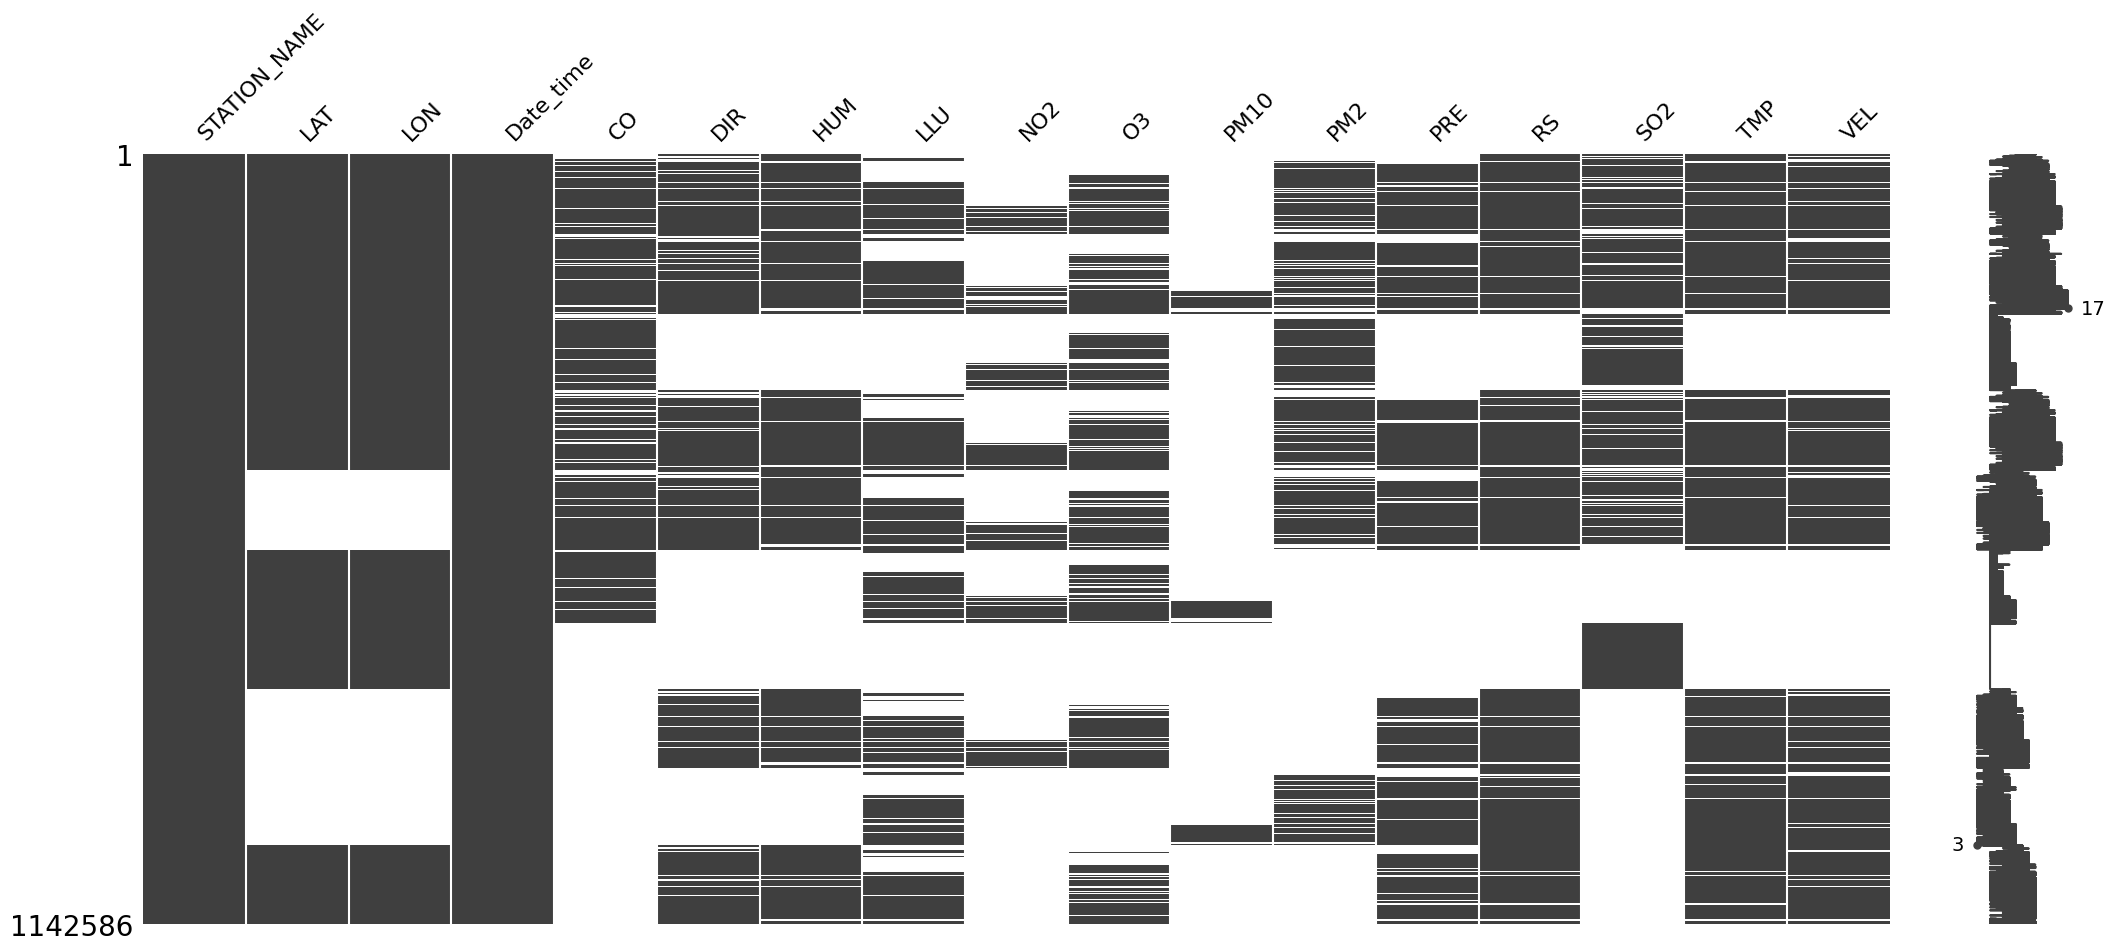

In [69]:
# Limpiar la columna Date_time eliminando caracteres no deseados
final_df["Date_time"] = final_df["Date_time"].astype(str).str.replace(r"\.0$", "", regex=True)

# Convertir la columna Date_time a formato datetime
final_df["Date_time"] = pd.to_datetime(final_df["Date_time"], errors="coerce")

# Verificar si hay valores no convertidos
if final_df["Date_time"].isnull().any():
    print("Advertencia: Algunos valores en 'Date_time' no se pudieron convertir. Revisa los datos.")
    display(final_df[final_df["Date_time"].isnull()])

# Continuar con el análisis
msno.matrix(final_df)

In [70]:
# Media mensual
monthly_df = final_df.set_index("Date_time").groupby("STATION_NAME").resample("ME").mean().reset_index()

# Media horaria
hourly_df = final_df.set_index("Date_time").groupby("STATION_NAME").resample("h").mean().reset_index()

# Mostrar una muestra de los DataFrames resultantes
display(final_df.head())
display(monthly_df.head())
display(hourly_df.head())

,STATION_NAME,LAT,LON,Date_time,CO,DIR,HUM,LLU,NO2,O3,PM10,PM2,PRE,RS,SO2,TMP,VEL
0,BELISARIO,-0.184731,-78.495989,2004-01-01 00:00:00,NaN,336.54,98.06,NaN,NaN,NaN,NaN,NaN,NaN,0.0,11.40,9.93,0.52
1,BELISARIO,-0.184731,-78.495989,2004-01-01 01:00:00,NaN,259.17,98.47,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.23,9.14,0.54
2,BELISARIO,-0.184731,-78.495989,2004-01-01 02:00:00,NaN,348.76,98.65,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.01,8.71,0.54
3,BELISARIO,-0.184731,-78.495989,2004-01-01 03:00:00,NaN,300.94,99.03,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.68,8.63,0.58
4,BELISARIO,-0.184731,-78.495989,2004-01-01 04:00:00,NaN,248.61,86.85,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.94,10.18,2.48


,STATION_NAME,Date_time,LAT,LON,CO,DIR,HUM,LLU,NO2,O3,PM10,PM2,PRE,RS,SO2,TMP,VEL
0,BELISARIO,2004-01-31,-0.184731,-78.495989,6.611429,139.025605,76.925726,0.011111,NaN,NaN,NaN,NaN,717.5925,210.336358,14.043162,11.696452,1.600860
1,BELISARIO,2004-02-29,-0.184731,-78.495989,4.771667,158.105287,82.133491,0.000000,NaN,NaN,NaN,NaN,720.6600,196.634511,18.263360,12.286638,1.476695
2,BELISARIO,2004-03-31,-0.184731,-78.495989,3.701250,161.730591,79.135874,0.025000,NaN,NaN,NaN,NaN,727.0200,205.073858,30.484095,12.993172,1.525591
3,BELISARIO,2004-04-30,-0.184731,-78.495989,3.748750,158.328818,86.034486,NaN,NaN,NaN,NaN,NaN,NaN,188.783028,24.688789,12.221972,1.415028
4,BELISARIO,2004-05-31,-0.184731,-78.495989,3.990000,146.166667,83.346398,0.000000,NaN,NaN,NaN,NaN,722.9600,202.786667,20.642549,12.749301,1.535908


,STATION_NAME,Date_time,LAT,LON,CO,DIR,HUM,LLU,NO2,O3,PM10,PM2,PRE,RS,SO2,TMP,VEL
0,BELISARIO,2004-01-01 00:00:00,-0.184731,-78.495989,NaN,336.54,98.06,NaN,NaN,NaN,NaN,NaN,NaN,0.0,11.40,9.93,0.52
1,BELISARIO,2004-01-01 01:00:00,-0.184731,-78.495989,NaN,259.17,98.47,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.23,9.14,0.54
2,BELISARIO,2004-01-01 02:00:00,-0.184731,-78.495989,NaN,348.76,98.65,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.01,8.71,0.54
3,BELISARIO,2004-01-01 03:00:00,-0.184731,-78.495989,NaN,300.94,99.03,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.68,8.63,0.58
4,BELISARIO,2004-01-01 04:00:00,-0.184731,-78.495989,NaN,248.61,86.85,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.94,10.18,2.48


## Exploratory Data Analysis (EDA)

Visualizaremos tendencias temporales, patrones estacionales y relaciones entre variables usando reducción de dimensionalidad.

In [73]:
# ===============================
# INGRESAR DESPUÉS DEL CÓDIGO DE CARGA Y LIMPIEZA
# ===============================

# Rellenar columnas faltantes con forward fill para evitar NaNs
final_df = final_df.sort_values(by="Date_time")
final_df.fillna(method='ffill', inplace=True)

# ===== Feature Engineering para PM2.5 =====
# Generar LAGs y media móvil para PM2.5 por estación
for lag in [1, 2, 3, 24, 168]:  # horas: 1, 2, 3, día, semana
    final_df[f'PM2.5_lag_{lag}'] = final_df.groupby('STATION_NAME')['PM2'].shift(lag)

final_df['PM2.5_roll_24h'] = final_df.groupby('STATION_NAME')['PM2'].rolling(window=24, min_periods=1).mean().reset_index(0, drop=True)

# Features temporales
final_df['hour'] = final_df['Date_time'].dt.hour
final_df['dayofweek'] = final_df['Date_time'].dt.dayofweek
final_df['month'] = final_df['Date_time'].dt.month
final_df['year'] = final_df['Date_time'].dt.year


C:\Users\user\AppData\Local\Temp\ipykernel_7752\3846815403.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df.fillna(method='ffill', inplace=True)


In [ ]:
# ===============================
# MODELADO para una estación específica
# ===============================

station = 'BELISARIO'  # Cambia por otras: CARAPUNGO, TUMBACO, etc.
df_station = final_df[final_df['STATION_NAME'] == station]

# Eliminar valores nulos que quedan
df_station = df_station.dropna(subset=['PM2'])

# Seleccionar variables de entrada y salida
features = [col for col in df_station.columns if 'lag' in col or 'roll' in col or col in ['hour', 'dayofweek', 'month', 'year']]
target = 'PM2'

X = df_station[features]
y = df_station[target]

# Verificar si hay suficientes datos
print("Muestras disponibles:", len(X))
if len(X) < 100:
    raise ValueError("No hay suficientes datos para modelar con TimeSeriesSplit. Usa otra estación o más datos.")

# Cross-validation temporal
tscv = TimeSeriesSplit(n_splits=5)
mae_list, mse_list, rmse_list, mape_list = [], [], [], []

plt.figure(figsize=(12, 6))

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    mape_list.append(mape)

    # Graficar
    plt.plot(y_test.index, y_test, label=f"Real Fold {i+1}", alpha=0.6)
    plt.plot(y_test.index, y_pred, label=f"Pred Fold {i+1}", alpha=0.6)

plt.title(f"Predicción PM2.5 - Estación {station}")
plt.xlabel("Índice temporal")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.tight_layout()
plt.show()

# Imprimir métricas
print("\nMétricas por fold:")
for i in range(len(mae_list)):
    print(f"Fold {i+1}: MAE={mae_list[i]:.2f}, RMSE={rmse_list[i]:.2f}, MAPE={mape_list[i]*100:.2f}%")

KeyError: 'PM2.5'